# Quantum Key Distribution

In [1]:
# boilerplate
import numpy as np
import pandas as pd
import matplotlib as plt
import os

# qiskit
from qiskit import QuantumCircuit, execute, Aer
from qiskit.visualization import plot_histogram, plot_bloch_multivector
from numpy.random import randint
from qiskit.providers.aer import QasmSimulator

# other classes I wrote
import Alice
import Bob
import Eve
import Encrypt

Fact: measuring a quibit can change its state. If Eve attempts to access the information contained in the qubit sent from Alice to Bob, i.e. by measuring it, then it is possible that the state of the qubit will be changed.



## Demo 1: Without Interception

In [2]:
e = Encrypt.Encrypt(32)
e.run_without_intercept()

True

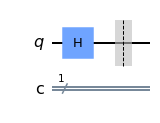

In [2]:
alice = Alice.Alice(32)
bob = Bob.Bob(32)
bits = alice.init_bitstring()
bases = alice.init_bases()
    
list = alice.encode_bitstring(bits, bases)
list[3].draw('mpl')

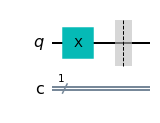

In [3]:
np.random.seed(seed=0)
n = 32

# Alice generates bits and bases
alice_bits = randint(2, size=n)
alice_bases = randint(2, size=n)

message = alice.encode_bitstring(alice_bits, alice_bases)
message[7].draw('mpl')

[0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0]


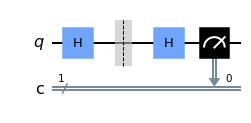

In [4]:
# now bob measures the message in a random sequence of bases of his choosing
bob_bases = randint(2, size=n)
bob_results = bob.measure_message(message, bob_bases) # this is the result for step 3.. bob keeps this result private
print(bob_results)
message[0].draw('mpl')

In [5]:
message[6].draw('mpl')
print(len(bob_results))

32


In [6]:
alice_key = alice.remove_garbage(alice_bases, bob_bases, alice_bits)
bob_key = bob.remove_garbage(alice_bases, bob_bases, bob_results)
print(f'Alice key = {alice_key}')
print(f'Bob key = {bob_key}')
print()

print(f'Len_alice = {len(alice_key)}')
print(f'Len_bob = {len(bob_key)}')
print()

print(alice_key == bob_key)

# now testing a random sample to make sure the protocol worked correctly
sample_size = 16
bit_selection = randint(n, size=sample_size)

bob_sample = bob.share_random_sample(bob_key, bit_selection)
print("bob_sample = " + str(bob_sample))
alice_sample = alice.share_random_sample(alice_key, bit_selection)
print("alice_sample = "+ str(alice_sample))


# if successful, true
print(bob_sample == alice_sample) 

Alice key = [0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0]
Bob key = [0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0]

Len_alice = 22
Len_bob = 22

True
bob_sample = [1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1]
alice_sample = [1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1]
True


## Demo 2: With Interception

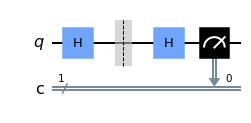

In [7]:
alice = Alice.Alice(32)
bob = Bob.Bob(32)
eve = Eve.Eve(32) # now, we need an eavesdropper


alice_bits = alice.init_bitstring()
alice_bases = alice.init_bases()
    
message = alice.encode_bitstring(alice_bits, alice_bases)
message[0].draw('mpl')

[1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0]


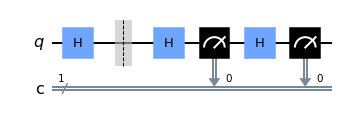

In [8]:
eve_bases = eve.init_bases()
intercept_message = eve.intercept_message(message, eve_bases)
print(intercept_message)
message[0].draw('mpl')

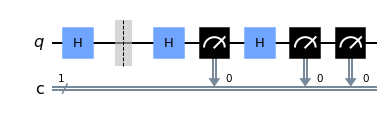

In [9]:
# Bob then checks like before and measures the message with his own choice of bases
bob_bases = bob.init_bases()
bob_results = bob.measure_message(message, bob_bases)
message[0].draw('mpl')

In [10]:
# just like before, Bob and Alice reveal choice of basis over Eve's public channel
bob_key = bob.remove_garbage(alice_bases, bob_bases, bob_results)
alice_key = alice.remove_garbage(alice_bases, bob_bases, alice_bits)

In [11]:
sample_size = 15
bit_selection = randint(32, size=sample_size)
bob_sample = bob.share_random_sample(bob_key, bit_selection)
print("  bob_sample = " + str(bob_sample))
alice_sample = alice.share_random_sample(alice_key, bit_selection)
print("alice_sample = "+ str(alice_sample))

  bob_sample = [1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1]
alice_sample = [1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1]


In [12]:
# either due to noise or eavesdropping, the message in void
print(bob_sample == alice_sample)

False


## Example of Quantum Algorithm: BB84

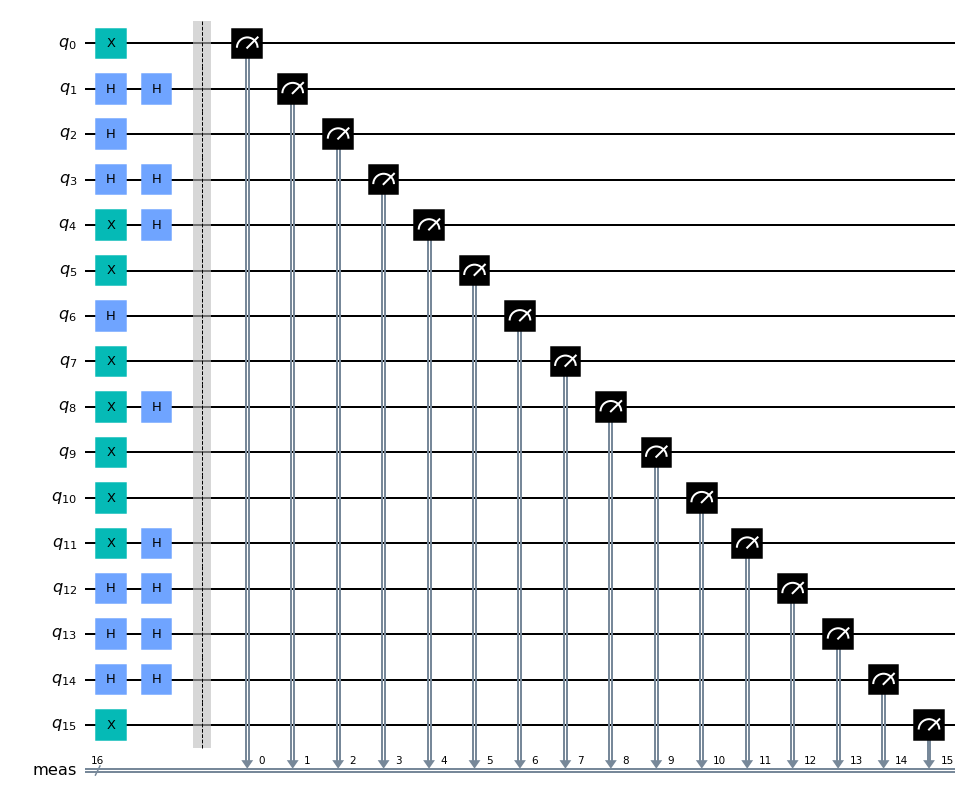

In [17]:
def bb84(state, basis, measurement):
    """
    Run the BB84 algorithm to run the QKD protocol
        @params:
            state       - Required  : the state of the qubits that want to be transmitted (int)
            basis       - Required  : the basis used to encode the state paramter above
            measurement - Required  : the measurement basis used when reciving the encoded message from the basis
                                      paramter

    """
    # initialize the circuit
    size = len(state)
    qc = QuantumCircuit(size)
    
    # iterate over the qubits in the basis: 
    # if 1, apply Pauli X, if 0, apply Hadamard
    for i in range(len(basis)):
        if state[i] == 1:
            qc.x(i)
        if state[i] == 0:
            qc.h(i)
    # after a transformation is applied to each qubit, measure
    for i in range(len(measurement)):
        if measurement[i] == 1:
            qc.h(i)
    qc.measure_all()
    
    return qc
    
num_qubits = 16

alice_basis = np.random.randint(2, size=num_qubits)
alice_bits = np.random.randint(2, size=num_qubits)
bob_basis = np.random.randint(2, size=num_qubits)

bb84(alice_bits, alice_basis, bob_basis).draw('mpl')